In [2]:
# Import Packages
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq, fftshift

In [3]:
# Functions

def video_to_array(input_filepath):
    videocap = cv2.VideoCapture(input_filepath)

    frameCount = int(videocap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth = int(videocap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHeight = int(videocap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Numpy matrix with grayscale intensities
    video_np_array = np.empty((frameCount, frameHeight, frameWidth), np.dtype('uint8'))

    for i in range(frameCount):
        videocap.set(1, i)
        success, frame_temp = videocap.read()
        if success:
            gray_temp = cv2.cvtColor(frame_temp, cv2.COLOR_BGR2GRAY)
            video_np_array[i] = gray_temp

    videocap.release()
    return video_np_array, frameCount


def split_video(video_matrix, n_split_axis):
    # n_split_axis is the number of times both axes are divided
    n_frames = video_matrix.shape[0]
    height = video_matrix.shape[1]
    width = video_matrix.shape[2]

    # Split video in ROIs
    spacing_h = int(height / n_split_axis)
    spacing_w = int(width / n_split_axis)
    h_prev = 0
    all_rois = []
    for i in range(n_split_axis):
        h_next = h_prev + spacing_h
        if (h_next >= height):
            h_next = height
        w_prev = 0
        for j in range(n_split_axis):
            w_next = w_prev + spacing_w
            if (w_next >= width):
                w_next = width
            temp_roi = video_matrix[:, h_prev:h_next, w_prev:w_next]
            all_rois.append(temp_roi)
            w_prev = w_prev + spacing_w
        h_prev = h_prev + spacing_h
    return all_rois


def get_average_intensity_roi(in_roi):
    temp_roi = np.array(in_roi)
    reshaped_roi = temp_roi.reshape(temp_roi.shape[0], temp_roi.shape[1] * temp_roi.shape[2])
    mean_signal = np.mean(reshaped_roi, axis=1)
    return mean_signal


def normalize_signals_and_cut(roi_signals, frame_count, cut_video_frame):
    centered_roi_signal = []
    for i in roi_signals:
        temp_roi_raw = get_average_intensity_roi(i)
        temp_roi = temp_roi_raw[0:frame_count - cut_video_frame]
        mean = np.ones(len(temp_roi)) * np.mean(temp_roi)
        temp_roi = temp_roi - mean
        centered_roi_signal.append(temp_roi)
    centered_roi_signal = np.array(centered_roi_signal)
    return centered_roi_signal


def get_roi_max_frequencies_fft(roi_signals, video_fps):
    N = len(roi_signals[0])
    # sample spacing
    T = 1.0 / video_fps
    x = np.linspace(0.0, N*T, N, endpoint=False)
    max_freqs = []
    for i in range(len(roi_signals)):
        temp_signal = roi_signals[i]
        temp_signal = temp_signal[0:N]
        y = temp_signal
        yf = fft(y)
        xf = fftfreq(N, T)[:N//2]
        # get frequency with max power
        y_p = 2.0/N * np.abs(yf[0:N//2])
        idx_max = np.argmax(y_p)
        max_freqs.append(xf[idx_max])
    return max_freqs


def process_videos_from_directory(path_directory, video_extension,
                                  video_fps, grid_split_size,
                                  final_frame, top_n_rois_per_video,
                                  path_save_np_signals='',
                                  save_np_signals=False):
    
    # Initialize arrays for dataframe 
    name_video = []
    roi_number = []
    roi_freq_Hz = []

    video_paths = os.listdir(path_directory)
    for video_temp_file_name in video_paths:
        if video_temp_file_name.endswith(video_extension):
            video_np_array, n_frames = video_to_array(path_directory+video_temp_file_name)
            roi_images = split_video(
                video_matrix=video_np_array,
                n_split_axis=grid_split_size,
            )
            centered_roi_signals = normalize_signals_and_cut(
                roi_signals=roi_images,
                frame_count=n_frames,
                cut_video_frame=final_frame,
            )

            video_temp_name = video_temp_file_name.split('.')[0]
            if save_np_signals:
                with open(path_save_np_signals + video_temp_name + '.npy', 'wb') as f:
                    np.save(f, centered_roi_signals)

            fft_frequencies = get_roi_max_frequencies_fft(
                roi_signals=centered_roi_signals,
                video_fps=video_fps,
            )

            fft_frequencies.sort()

            for j in range(top_n_rois_per_video):
                name_video.append(video_temp_name)
                roi_number.append(j)
                temp_freq = fft_frequencies[-j]
                roi_freq_Hz.append(temp_freq)

        data = {
            'name_video': name_video,
            'roi_number': roi_number,
            'frequency': roi_freq_Hz,
        }

        df_roi_freqs = pd.DataFrame.from_dict(data)

    return df_roi_freqs


In [4]:
INPUT_FILEPATH = 'data/raw/'
VIDEO_FPS = 50  # fps of the video recordings
N_SIDE_GRID = 10  # split video frames in a grid of NxN rois
CUT_VIDEO_FRAME = 950  # final frame to cut off the video
VIDEO_EXTENSION = '.MOV'  # extension of video files
TOP_N_FREQ_PER_VIDEO = 10  # save the top N roi frequencies
PATH_SAVE_NP_SIGNALS = 'data/processed/roi_mean_signals/'
PATH_SAVE_CSV = 'data/processed/'
SAVE_PROCESSED_SIGNALS = True

In [ ]:
df_frequencies = process_videos_from_directory(
    path_directory=INPUT_FILEPATH,
    video_fps=VIDEO_FPS,
    grid_split_size=N_SIDE_GRID,
    final_frame=CUT_VIDEO_FRAME,
    video_extension=VIDEO_EXTENSION,
    top_n_rois_per_video=TOP_N_FREQ_PER_VIDEO,
    path_save_np_signals=PATH_SAVE_NP_SIGNALS,
    save_np_signals=SAVE_PROCESSED_SIGNALS,
)

path_save_csv = PATH_SAVE_CSV + 'results.csv'
df_frequencies.to_csv(path_save_csv, index=False)

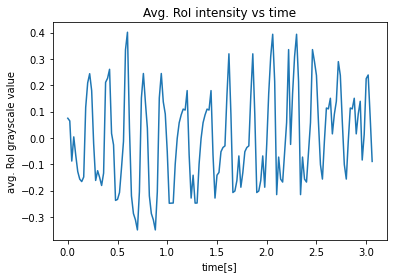

In [12]:
# Plot Sample Signal
SAMPLE_VIDEO_NAME=''

temp_roi_path = '../data/processed/roi_mean_signals/' + SAMPLE_VIDEO_NAME + '.npy'
with open(temp_roi_path, 'rb') as f:
    centered_roi_signal = np.load(f)

roi_i=3
y = centered_roi_signal[roi_i]
x = np.arange(0,len(y))*0.02
plt.xlabel('time[s]')
plt.ylabel('avg. RoI grayscale value')
plt.title('Avg. RoI intensity vs time')
plt.plot(x,y)
plt.show()

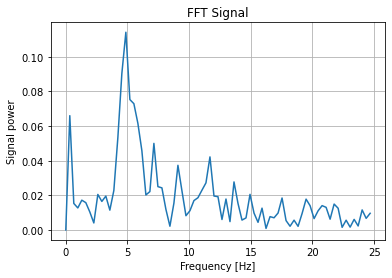

In [17]:
# Number of sample points
N = len(y)
# sample spacing
T = 1.0 / VIDEO_FPS
x = np.linspace(0.0, N*T, N, endpoint=False)
y = centered_roi_signal[roi_i]

yf = fft(y)
xf = fftfreq(N, T)[:N//2]

# get frecuency with max power
y_plot = 2.0/N * np.abs(yf[0:N//2])

plt.plot(xf, y_plot)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Signal power')
plt.title('FFT Signal')
plt.grid()
plt.show()